In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from IPython.display import display, clear_output
%matplotlib inline

In [4]:
# Units and constants

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

# TlF constants. Data from D.A. Wilkening, N.F. Ramsey,
# and D.J. Larson, Phys Rev A 29, 425 (1984). Everything in Hz.

Brot = 6689920000
c1 = 126030.0
c2 = 17890.0
c3 = 700.0
c4 = -13300.0

D_TlF = 4.2282 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]

# Constants from Wilkening et al, in Hz/Gauss, for 205Tl

mu_J = 35
mu_Tl = 1240.5
mu_F = 2003.63

In [5]:
def set_fontsize(ax, fs, legend = False):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.yaxis.offsetText.set_fontsize(fs)
    if legend:
        [t.set_fontsize(fs) for t in ax.legend().get_texts()]
    ax.title.set_size(int(fs*1.2))

In [6]:
class BasisState:
    # constructor
    def __init__(self, J, mJ, I1, m1, I2, m2):
        self.J, self.mJ  = J, mJ
        self.I1, self.m1 = I1, m1
        self.I2, self.m2 = I2, m2

    # equality testing
    def __eq__(self, other):
        return self.J==other.J and self.mJ==other.mJ \
                    and self.I1==other.I1 and self.I2==other.I2 \
                    and self.m1==other.m1 and self.m2==other.m2

    # inner product
    def __matmul__(self, other):
        if self == other:
            return 1
        else:
            return 0

    # superposition: addition
    def __add__(self, other):
        if self == other:
            return State([ (2,self) ])
        else:
            return State([ (1,self), (1,other) ])

    # superposition: subtraction
    def __sub__(self, other):
        return self + -1*other

    # scalar product (psi * a)
    def __mul__(self, a):
        return State([ (a, self) ])

    # scalar product (a * psi)
    def __rmul__(self, a):
        return self * a
    
    def print_quantum_numbers(self):
        print( self.J,"%+d"%self.mJ,"%+0.1f"%self.m1,"%+0.1f"%self.m2 )

In [7]:
class State:
    # constructor
    def __init__(self, data=[], remove_zero_amp_cpts=True):
        # check for duplicates
        for i in range(len(data)):
            amp1,cpt1 = data[i][0], data[i][1]
            for amp2,cpt2 in data[i+1:]:
                if cpt1 == cpt2:
                    raise AssertionError("duplicate components!")
        # remove components with zero amplitudes
        if remove_zero_amp_cpts:
            self.data = [(amp,cpt) for amp,cpt in data if amp!=0]
        else:
            self.data = data
        # for iteration over the State
        self.index = len(self.data)

    # superposition: addition
    # (highly inefficient and ugly but should work)
    def __add__(self, other):
        data = []
        # add components that are in self but not in other
        for amp1,cpt1 in self.data:
            only_in_self = True
            for amp2,cpt2 in other.data:
                if cpt2 == cpt1:
                    only_in_self = False
            if only_in_self:
                data.append((amp1,cpt1))
        # add components that are in other but not in self
        for amp1,cpt1 in other.data:
            only_in_other = True
            for amp2,cpt2 in self.data:
                if cpt2 == cpt1:
                    only_in_other = False
            if only_in_other:
                data.append((amp1,cpt1))
        # add components that are both in self and in other
        for amp1,cpt1 in self.data:
            for amp2,cpt2 in other.data:
                if cpt2 == cpt1:
                    data.append((amp1+amp2,cpt1))
        return State(data)
                
    # superposition: subtraction
    def __sub__(self, other):
        return self + -1*other

    # scalar product (psi * a)
    def __mul__(self, a):
        return State( [(a*amp,psi) for amp,psi in self.data] )

    # scalar product (a * psi)
    def __rmul__(self, a):
        return self * a
    
    # scalar division (psi / a)
    def __truediv__(self, a):
        return self * (1/a)
    
    # negation
    def __neg__(self):
        return -1.0 * self
    
    # inner product
    def __matmul__(self, other):
        result = 0
        for amp1,psi1 in self.data:
            for amp2,psi2 in other.data:
                result += amp1.conjugate()*amp2 * (psi1@psi2)
        return result

    # iterator methods
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.index == 0:
            raise StopIteration
        self.index -= 1
        return self.data[self.index]
    
    # direct access to a component
    def __getitem__(self, i):
        return self.data[i]

In [8]:
def J2(psi):
    return State([(psi.J*(psi.J+1),psi)])

def Jz(psi):
    return State([(psi.mJ,psi)])

def I1z(psi):
    return State([(psi.m1,psi)])

def I2z(psi):
    return State([(psi.m2,psi)])

In [9]:
def Jp(psi):
    amp = sqrt((psi.J-psi.mJ)*(psi.J+psi.mJ+1))
    ket = BasisState(psi.J, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp,ket)])

def Jm(psi):
    amp = sqrt((psi.J+psi.mJ)*(psi.J-psi.mJ+1))
    ket = BasisState(psi.J, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I1p(psi):
    amp = sqrt((psi.I1-psi.m1)*(psi.I1+psi.m1+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1+1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I1m(psi):
    amp = sqrt((psi.I1+psi.m1)*(psi.I1-psi.m1+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1-1, psi.I2, psi.m2)
    return State([(amp,ket)])

def I2p(psi):
    amp = sqrt((psi.I2-psi.m2)*(psi.I2+psi.m2+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2+1)
    return State([(amp,ket)])

def I2m(psi):
    amp = sqrt((psi.I2+psi.m2)*(psi.I2-psi.m2+1))
    ket = BasisState(psi.J, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2-1)
    return State([(amp,ket)])

In [10]:
def Jx(psi):
    return .5*( Jp(psi) + Jm(psi) )

def Jy(psi):
    return -.5j*( Jp(psi) - Jm(psi) )

def I1x(psi):
    return .5*( I1p(psi) + I1m(psi) )

def I1y(psi):
    return -.5j*( I1p(psi) - I1m(psi) )

def I2x(psi):
    return .5*( I2p(psi) + I2m(psi) )

def I2y(psi):
    return -.5j*( I2p(psi) - I2m(psi) )

In [11]:
def com(A, B, psi):
    ABpsi = State()
    # operate with A on all components in B|psi>
    for amp,cpt in B(psi):
        ABpsi += amp * A(cpt)
    return ABpsi

In [12]:
def Hrot(psi):
    return Brot * J2(psi)

In [13]:
def Hc1(psi):
    return c1 * ( com(I1z,Jz,psi) + .5*(com(I1p,Jm,psi)+com(I1m,Jp,psi)) )

def Hc2(psi):
    return c2 * ( com(I2z,Jz,psi) + .5*(com(I2p,Jm,psi)+com(I2m,Jp,psi)) )

def Hc4(psi):
    return c4 * ( com(I1z,I2z,psi) + .5*(com(I1p,I2m,psi)+com(I1m,I2p,psi)) )

def Hc3a(psi):
    return 15*c3/c1/c2 * com(Hc1,Hc2,psi) / ((2*psi.J+3)*(2*psi.J-1))

def Hc3b(psi):
    return 15*c3/c1/c2 * com(Hc2,Hc1,psi) / ((2*psi.J+3)*(2*psi.J-1))

def Hc3c(psi):
    return -10*c3/c4/Brot * com(Hc4,Hrot,psi) / ((2*psi.J+3)*(2*psi.J-1))

In [14]:
def Hff(psi):
    return Hrot(psi) + Hc1(psi) + Hc2(psi) + Hc3a(psi) + Hc3b(psi) \
            + Hc3c(psi) + Hc4(psi)

In [15]:
def HZx(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jx(psi) - mu_Tl/psi.I1*I1x(psi) - mu_F/psi.I2*I2x(psi)
    else:
        return -mu_Tl/psi.I1*I1x(psi) - mu_F/psi.I2*I2x(psi)

def HZy(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jy(psi) - mu_Tl/psi.I1*I1y(psi) - mu_F/psi.I2*I2y(psi)
    else:
        return -mu_Tl/psi.I1*I1y(psi) - mu_F/psi.I2*I2y(psi)
    
def HZz(psi):
    if psi.J != 0:
        return -mu_J/psi.J*Jz(psi) - mu_Tl/psi.I1*I1z(psi) - mu_F/psi.I2*I2z(psi)
    else:
        return -mu_Tl/psi.I1*I1z(psi) - mu_F/psi.I2*I2z(psi)

In [16]:
def R10(psi):
    amp1 = sqrt((psi.J-psi.mJ)*(psi.J+psi.mJ)/(8*psi.J**2-2))
    ket1 = BasisState(psi.J-1, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = sqrt((psi.J-psi.mJ+1)*(psi.J+psi.mJ+1)/(6+8*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

def R1m(psi):
    amp1 = -.5*sqrt((psi.J+psi.mJ)*(psi.J+psi.mJ-1)/(4*psi.J**2-1))
    ket1 = BasisState(psi.J-1, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = .5*sqrt((psi.J-psi.mJ+1)*(psi.J-psi.mJ+2)/(3+4*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ-1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

def R1p(psi):
    amp1 = -.5*sqrt((psi.J-psi.mJ)*(psi.J-psi.mJ-1)/(4*psi.J**2-1))
    ket1 = BasisState(psi.J-1, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    amp2 = .5*sqrt((psi.J+psi.mJ+1)*(psi.J+psi.mJ+2)/(3+4*psi.J*(psi.J+2)))
    ket2 = BasisState(psi.J+1, psi.mJ+1, psi.I1, psi.m1, psi.I2, psi.m2)
    return State([(amp1,ket1),(amp2,ket2)])

In [17]:
def HSx(psi):
    return -D_TlF * ( R1m(psi) - R1p(psi) )

def HSy(psi):
    return -D_TlF * 1j * ( R1m(psi) + R1p(psi) )

def HSz(psi):
    return -D_TlF * sqrt(2)*R10(psi)

In [18]:
def HI1R(psi):
    return com(I1z,R10,psi) + .5*(com(I1p,R1m,psi)+com(I1m,R1p,psi))

def HI2R(psi):
    return com(I2z,R10,psi) + .5*(com(I2p,R1m,psi)+com(I2m,R1p,psi))

In [19]:
def Hc3_alt(psi):
    return 5*c3/c4*Hc4(psi) - 15*c3/2*(com(HI1R,HI2R,psi)+com(HI2R,HI1R,psi))

In [20]:
def Hff_alt(psi):
    return Hrot(psi) + Hc1(psi) + Hc2(psi) + Hc3_alt(psi) + Hc4(psi)

In [21]:
Jmax = 6
QN = np.array([BasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J in range(Jmax+1)
      for mJ in range(-J,J+1)
      for m1 in np.arange(-I_Tl,I_Tl+1)
      for m2 in np.arange(-I_F,I_F+1)])

In [22]:
%%time
def HMatElems(H, QN):
    result = np.empty((len(QN),len(QN)), dtype=complex)
    for i,a in enumerate(QN):
        for j,b in enumerate(QN):
            result[i,j] = (1*a)@H(b)
    return result

Hff_m = HMatElems(Hff, QN)
HSx_m = HMatElems(HSx, QN)
HSy_m = HMatElems(HSy, QN)
HSz_m = HMatElems(HSz, QN)
HZx_m = HMatElems(HZx, QN)
HZy_m = HMatElems(HZy, QN)
HZz_m = HMatElems(HZz, QN)

Wall time: 54.6 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


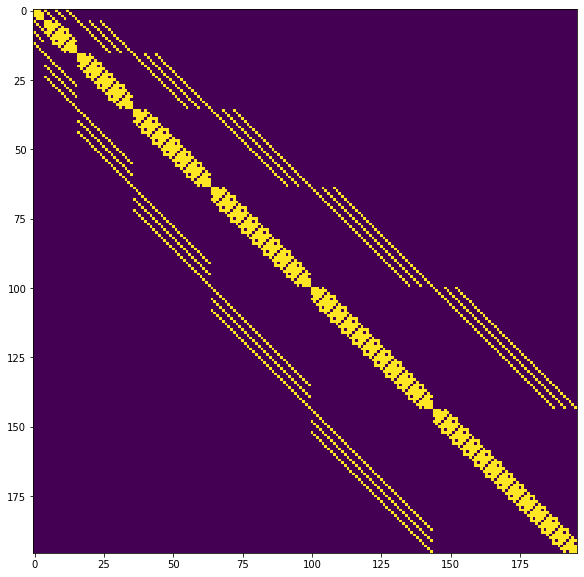

In [23]:
H = Hff_m + HSx_m + HSy_m + HSz_m + HZx_m + HZy_m + HZz_m
H[H != 0] = 1
H = H.astype(int)

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(H)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


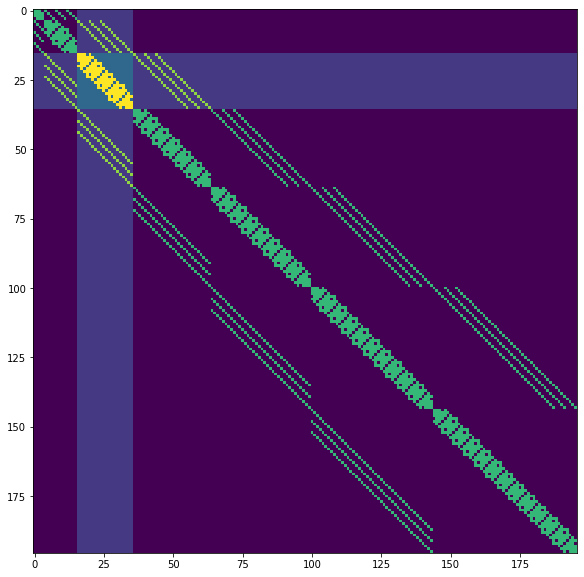

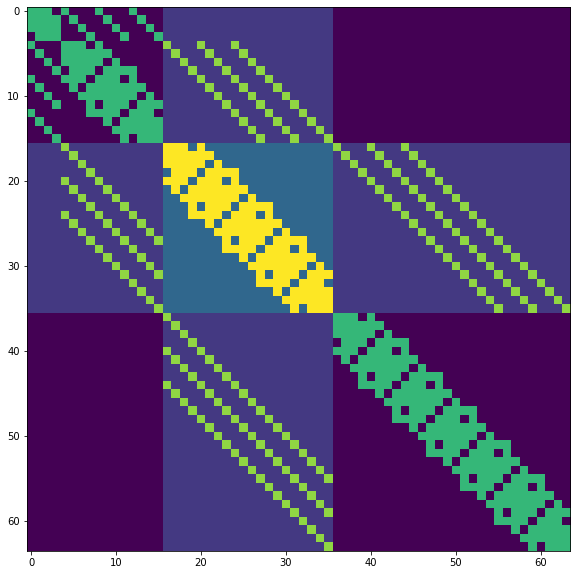

In [24]:
H = Hff_m + HSx_m + HSy_m + HSz_m + HZx_m + HZy_m + HZz_m
H[H != 0] = 1
H = H.astype(int)

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(H[:64,:64])

# Effective Hamiltonian Toy Model with H$_{rot}$ and H$_{stark}$

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


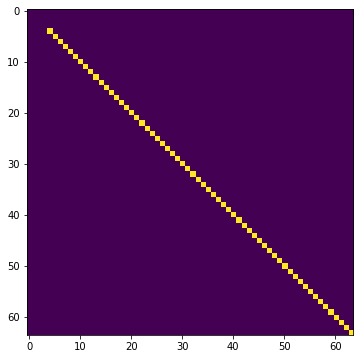

In [25]:
JmaxPlot = np.sum([4*(2*i+1) for i in range(4)])
H = HMatElems(Hrot, QN)
H[H != 0] = 1
H = H.astype(int)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:JmaxPlot,:JmaxPlot])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


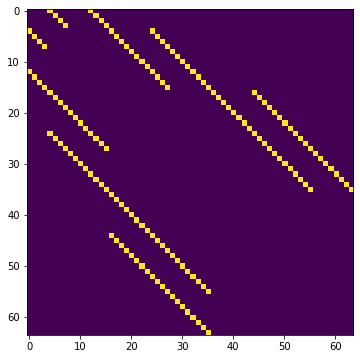

In [26]:
H = HMatElems(HSx, QN)
H[H != 0] = 1
H = H.astype(int)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:JmaxPlot,:JmaxPlot])

### R$_1^0$ Operator

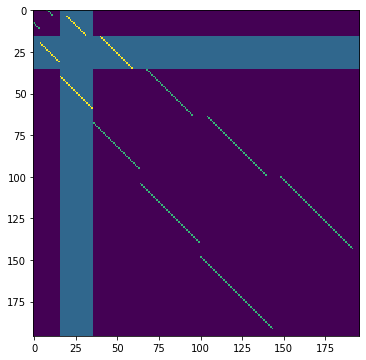

In [27]:
H = HMatElems(R10, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] = 0.5
Z[16:36,:] = 0.5

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

### R$_1^{-1}$ Operator

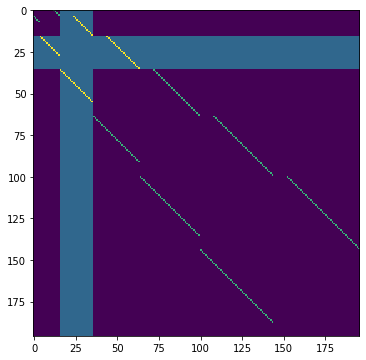

In [28]:
H = HMatElems(R1m, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] = 0.5
Z[16:36,:] = 0.5

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

### R$_1^1$ Operator

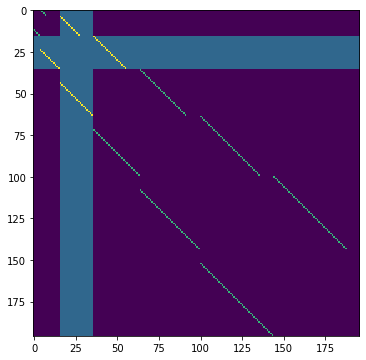

In [29]:
H = HMatElems(R1p, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] = 0.5
Z[16:36,:] = 0.5

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

### Hs$_z$ operator

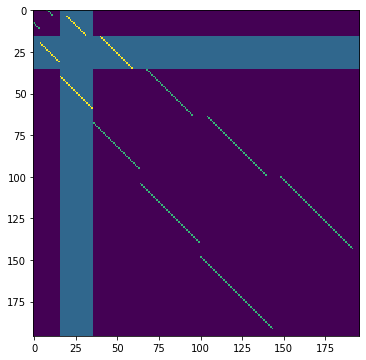

In [30]:
H = HMatElems(HSz, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] = 0.5
Z[16:36,:] = 0.5

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

### Generating Effective Hamiltonian matrices for $\lambda$ and $\lambda^2$

In [148]:
def generate_effective_1st(QN, H, eta):
    l = 4*(2*eta+1)
    start = int(np.sum([4*(2*i+1) for i in range(eta)]))
    Heff = np.zeros([l, l], dtype = 'complex')
    for i in range(l):
        for j in range(l):
            Heff[i,j]= (1*QN[start+i])@H(QN[start+j])
    return Heff

def generate_effective_2nd(QN, H1, H2, H0, eta, etamax):
    E0, _ = np.linalg.eigh(H0)
    E0 = np.unique(E0)
    l = 4*(2*eta+1)
    start = int(np.sum([4*(2*i+1) for i in range(eta)]))
    Heff = np.zeros([l, l], dtype = 'complex')
    for i in range(l):
        for j in range(l):
            val = 0
            for etad in range(etamax+1):
                start_etad = int(np.sum([4*(2*i+1) for i in range(etad)]))
                l_etad = 4*(2*etad+1)
                if etad != eta:
                    for k in range(l_etad):
                        val += ( np.conjugate((1*QN[start+i])@H1(QN[start_etad+k])) * (1*QN[start_etad+k])@H2(QN[start+j]) ) / (E0[eta] - E0[etad])
            Heff[i,j] = val
    return Heff

# def generate_effective_3rd(Qn, H1, H2, H0, eta, eta_max):
#     E0, _ = np.linalg.eigh(H0)
#     E0 = np.unique(E0)
#     s = 4*(2*eta+1)
#     start = int(np.sum([4*(2*i+1) for i in range(eta)]))
#     Heff = np.zeros([s, s], dtype = 'complex')
#     for i in range(s):
#         for j in range(s):
#             val = 0
#             for etad in range(eta_max+1):
#                 if etad == eta:
#                     continue
#                 start_etad = int(np.sum([4*(2*i+1) for i in range(etad)]))
#                 s_etad = 4*(2*etad+1)
#                 for etadd in range(eta_max+1):
#                     if etadd == eta:
#                         continue
#                     start_etadd = int(np.sum([4*(2*i+1) for i in range(etad)]))
#                     s_etadd = 4*(2*etadd+1)
#                     for k in range(s_etad):
#                         for l in range(s_etadd):
#                             tmp = ( (1*QN[start+i])@H(QN[start_etad+k]) * (1*QN[start_etad+k])@H(QN[start_etadd+l]) * (1*QN[start_etadd+l])@H(QN[start+k]))
#                             val += tmp/( (E0[eta]-E0[etad]) * (E0[eta]-E0[etad]))
#     for i in range(s):
#         for j in range(s):
#             val = 0
#             for etad in range(eta_max+1):
#                 if etad == eta:
#                     continue
#                 start_etad = int(np.sum([4*(2*i+1) for i in range(etad)]))
#                 s_etad = 4*(2*etad+1)
#                 for k in range(s_etad)
                    

# def generate_effective_2nd(QN, H, H0, start, stop):
#     E0, _ = np.linalg.eigh(H0)
#     l = stop-start
#     Heff = np.zeros([l, l], dtype = 'complex')
#     for idx in range(start,stop):
#         val = 0
#         for idy in range(0,len(QN)):
#             if idy not in range(start,stop):
#                 val += (1*QN[idx])@(H(QN[idy]))*(1*QN[idy])@H(QN[idx])/(E0[idx]-E0[idy])
#         Heff[idx-start,idx-start] = val
#     return Heff


def generate_effective_1st_matrix(Hmat, eta):
    idx_min = np.sum([4*(2*J+1) for J in range(eta)])
    idx_max = np.sum([4*(2*J+1) for J in range(eta+1)])
    P0 = P.copy()
    P0[:idx_min,:] = 0
    P0[:,:idx_min] = 0
    P0[idx_max:, :] = 0
    P0[:, idx_max:] = 0
    
    return (P0@Hmat@P0)[idx_min:idx_max, idx_min:idx_max]

def generate_effective_2nd_matrix(H0, Hmat1, Hmat2, eta):
    idx_min = np.sum([4*(2*J+1) for J in range(eta)])
    idx_max = idx_min + 4*(2*eta+1)
    P0 = np.eye(np.sum([4*(2*J+1) for J in range(Jmax+1)]))
    P0[:idx_min,:] = 0
    P0[:,:idx_min] = 0
    P0[idx_max:, :] = 0
    P0[:, idx_max:] = 0
    Q0 = np.eye(len(P0))
    
    Q0[idx_min:idx_max,idx_min:idx_max] = 0
    E, _ = np.linalg.eigh(H0)
    E = np.unique(E)
    for J in range(Jmax+1):
        if J == eta:
            continue
        idmin = int(np.sum([4*(2*j+1) for j in range(J)]))
        idmax = idmin + int(4*(2*J+1))
        Q0[idmin:idmax,idmin:idmax] /= E[eta] - E[J]
    
    return (P0@Hmat1@Q0@Hmat2@P0)[idx_min:idx_max, idx_min:idx_max]

def generate_effective_3rd_matrix(H0, Hmat1, Hmat2, Hmat3, eta):
    idx_min = np.sum([4*(2*J+1) for J in range(eta)])
    idx_max = idx_min + 4*(2*eta+1)
    P0 = np.eye(np.sum([4*(2*J+1) for J in range(Jmax+1)]))
    P0[:idx_min,:] = 0
    P0[:,:idx_min] = 0
    P0[idx_max:, :] = 0
    P0[:, idx_max:] = 0
    
    Q = np.eye(len(P0))
    Q[idx_min:idx_max,idx_min:idx_max] = 0
    E, _ = np.linalg.eigh(H0)
    E = np.unique(E)
    def gen_Q0a(a):
        Q0 = Q.copy()
        for J in range(Jmax+1):
            if J == eta:
                continue
            idmin = int(np.sum([4*(2*j+1) for j in range(J)]))
            idmax = idmin + int(4*(2*J+1))
            Q0[idmin:idmax,idmin:idmax] /= (E[eta] - E[J])**a
        return Q0
            
    Q0 = gen_Q0a(1)
    Q0_2 = gen_Q0a(2)
    
    return (P0@Hmat1@Q0@Hmat2@Q0@Hmat3@P0 - P0@Hmat1@Q0_2@Hmat2@P0@Hmat3@P0)[idx_min:idx_max,idx_min:idx_max]

def generate_effective_4th_matrix(H0, Hmat1, Hmat2, Hmat3, Hmat4, eta):
    idx_min = np.sum([4*(2*J+1) for J in range(eta)])
    idx_max = idx_min + 4*(2*eta+1)
    P0 = np.eye(np.sum([4*(2*J+1) for J in range(Jmax+1)]))
    P0[:idx_min,:] = 0
    P0[:,:idx_min] = 0
    P0[idx_max:, :] = 0
    P0[:, idx_max:] = 0
    
    Q = np.eye(len(P0))
    Q[idx_min:idx_max,idx_min:idx_max] = 0
    E, _ = np.linalg.eigh(H0)
    E = np.unique(E)
    def gen_Q0a(a):
        Q0 = Q.copy()
        for J in range(Jmax+1):
            if J == eta:
                continue
            idmin = int(np.sum([4*(2*j+1) for j in range(J)]))
            idmax = idmin + int(4*(2*J+1))
            Q0[idmin:idmax,idmin:idmax] /= (E[eta] - E[J])**a
        return Q0
            
    Q0 = gen_Q0a(1)
    Q0_2 = gen_Q0a(2)
    Q0_3 = gen_Q0a(2)
    
    val =  P0@Hmat1@Q0@Hmat2@Q0@Hmat3@Q0@Hmat4@P0
    val -= P0@Hmat1@Q0@Hmat2@Q0_2@Hmat3@P0@Hmat4@P0
    val -= P0@Hmat1@Q0_2@Hmat2@Q0@Hmat3@P0@Hmat4@P0
    val += P0@Hmat1@Q0_3@Hmat2@P0@Hmat3@P0@Hmat4@P0
    val -= P0@HMat1@Q0_2@P0@Hmat3@Q0@Hmat4@P0
    
    return val[idx_min:idx_max,idx_min:idx_max]
    
    
def compare_effective_matrices(M1, M2):
    idx = np.where(M1 != M2)
    return ((M1-M2)/M2)[idx]

In [162]:
dict([(1,2)])[1]

2

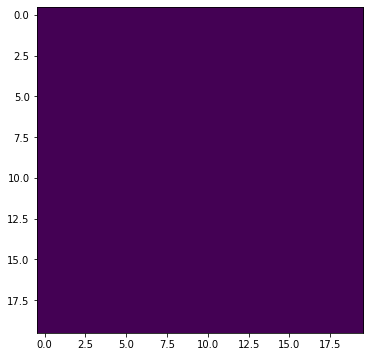

In [40]:
H0 = HMatElems(Hrot, QN)
HSx_eff1st= generate_effective_1st(QN, HSx, 2)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.abs(HSx_eff1st))

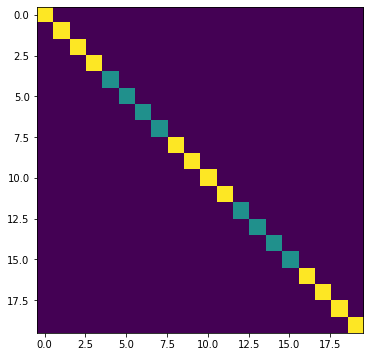

In [41]:
H0 = HMatElems(Hrot, QN)
HSz_eff2nd = generate_effective_2nd(QN, HSz, HSz, H0, 2, 6)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.abs(HSz_eff2nd))

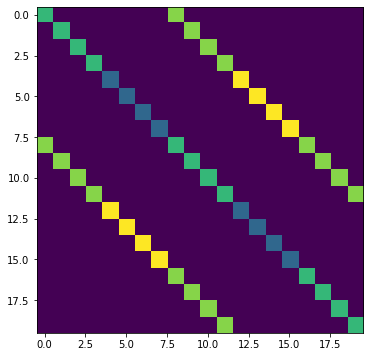

In [42]:
HSx_eff2nd = generate_effective_2nd(QN, HSx, HSx, H0, 2,6)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.abs(HSx_eff2nd))

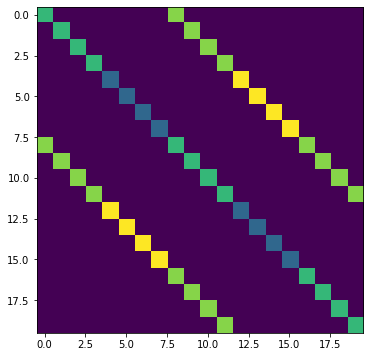

In [43]:
HSy_eff2nd = generate_effective_2nd(QN, HSy, HSy, H0, 2,6)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.abs(HSy_eff2nd))

In [44]:
Hrot_m = HMatElems(Hrot,QN)

def Hfull(Ex, Ey, Ez):
    return Hrot_m + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m

In [125]:
%%time
import itertools

HS_terms = [HSx, HSy, HSz]
Heff_terms = [generate_effective_2nd(QN, H1, H2, H0, 2, 6) for H1, H2 in itertools.product(HS_terms, HS_terms)]

Wall time: 1min 2s


In [149]:
%%time
import itertools

HS_terms = [HSx_m, HSy_m, HSz_m]
Heff_terms = [generate_effective_2nd_matrix(H0, H1, H2, 2) for H1, H2 in itertools.product(HS_terms, HS_terms)]
Heff_terms_3rd = [generate_effective_3rd_matrix(H0, H1, H2, H3, 2) for H1, H2, H3 in itertools.product(HS_terms, HS_terms, HS_terms)]

Wall time: 371 ms


In [130]:
[a+b for a,b in itertools.product(['x','y','z'], ['x','y','z'])]

['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz']

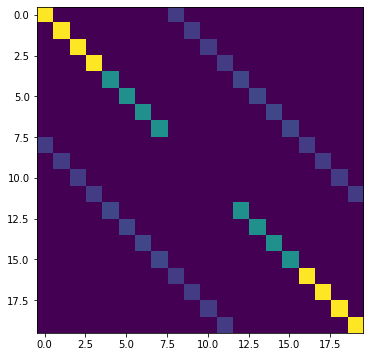

In [121]:
fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(np.abs(Heff_terms[1]))

In [126]:
def Heff(Ex,Ey,Ez):
    E = [Ex, Ey, Ez]
    tmp = Hrot_m[16:36,16:36].copy()
    for (E1, E2), Hi in zip(itertools.product(E, E), Heff_terms):
        if E1 != 0:
            if E2 != 0:
                tmp += E1*E2*Hi
    return tmp

In [127]:
# def Heff(Ex,Ey,Ez):
#     return Hrot_m[16:36,16:36] + Ex**2*Heff_terms[0] + Ey**2*Heff_terms[5] + Ez**2*Heff_terms[8]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


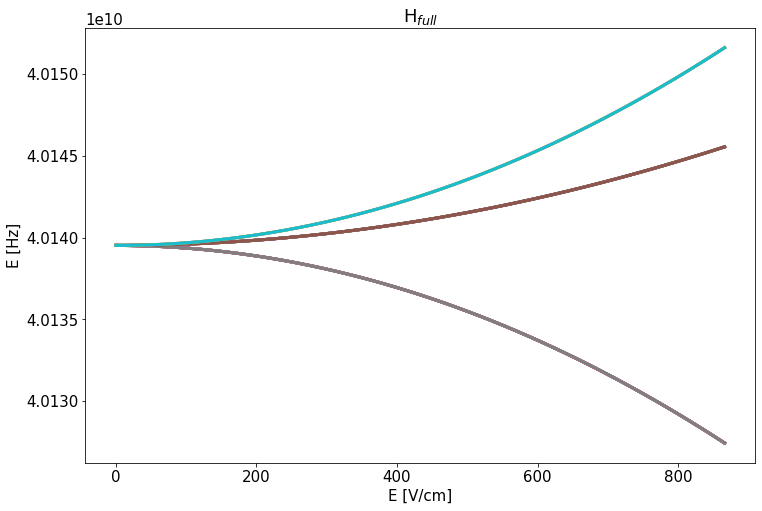

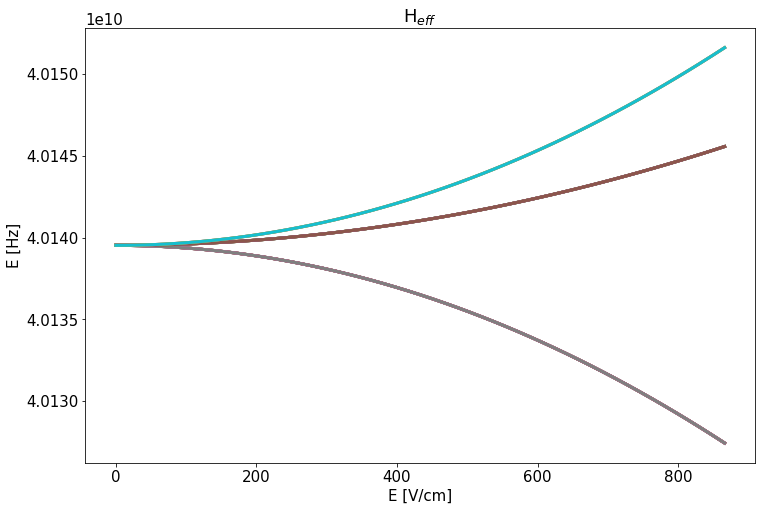

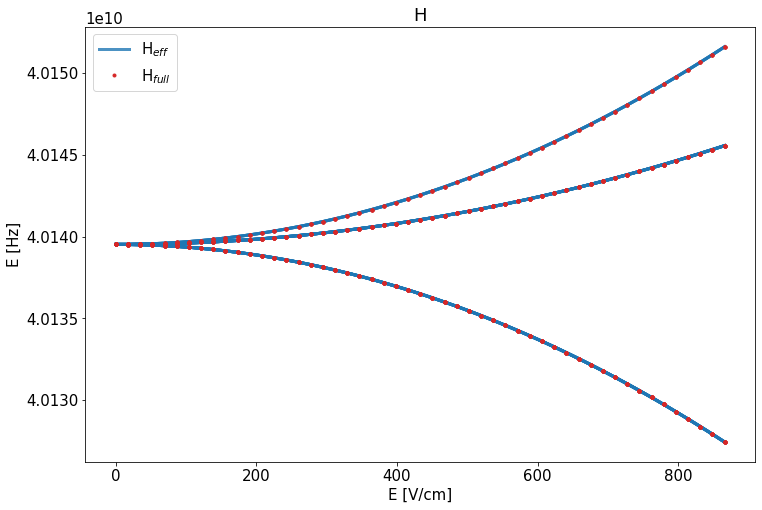

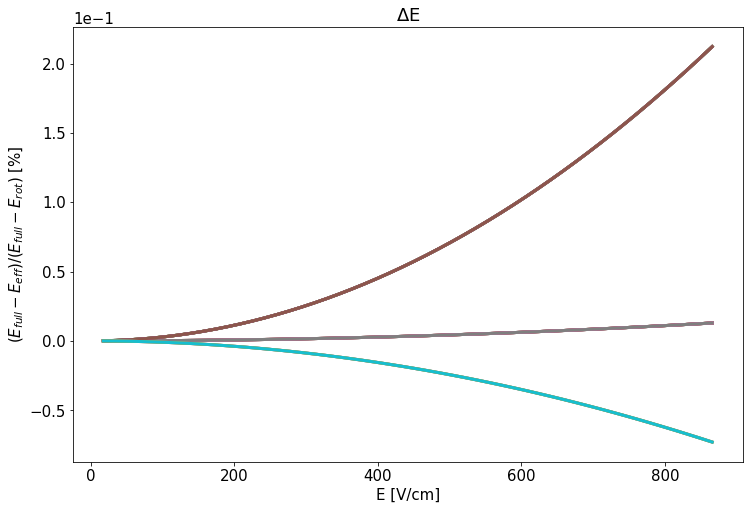

In [167]:
Emax = 500
Ez = np.linspace(0,Emax,51)
# Ez = np.zeros([51])
Ex = np.linspace(0,Emax,51)
# Ex = np.zeros([51])
Ey = np.linspace(0,Emax,51)
# Ey = np.zeros([51])
E = np.linalg.norm([Ex,Ey,Ez], axis = 0)


Hfull_numerical = np.array([Hfull(Exi,Eyi,Ezi) for Exi,Eyi,Ezi in zip(Ex, Ey, Ez)])
energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

Heff_numerical = np.array([Heff(Exi,Eyi,Ezi) for Exi,Eyi,Ezi in zip(Ex,Ey,Ez)])
energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, energies_full[:,16:36], '-', lw = 3);
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, energies_eff, '-', lw = 3);
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H$_{eff}$')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(E, energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(E, energies_full[:,16:36], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_xlabel(r'E [V/cm]')
ax.set_title(r'H')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E, 100*(energies_eff-energies_full[:,16:36])/(energies_full[:,16:36] - energies_full[0,16:36]), lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel(r'E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/\left(E_{full}-E_{rot}\right)$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

# Checking Other Hamiltonian Terms
- Hff_m
- HSx_m
- HSy_m
- HSz_m
- HZx_m
- HZy_m
- HZz_m

Now lets only look at the terms comprising Hff

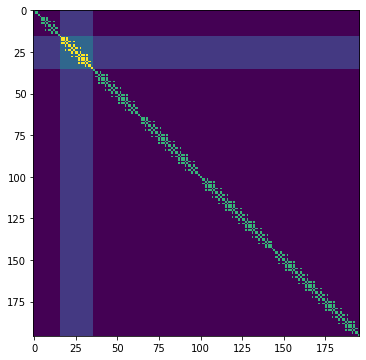

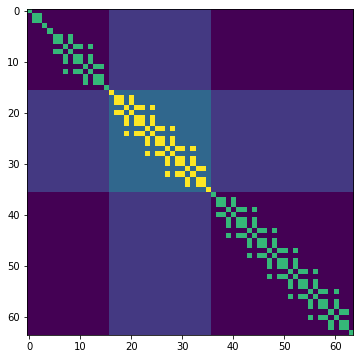

In [77]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = np.abs(Hff_m.copy())
H[H != 0] = 1

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

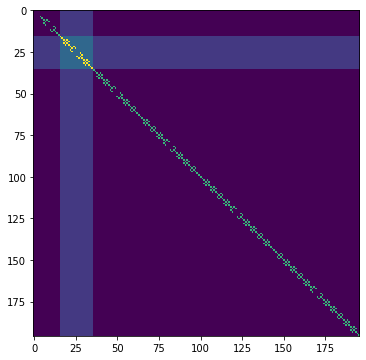

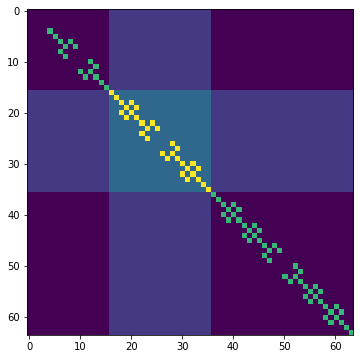

In [78]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = HMatElems(Hc1, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

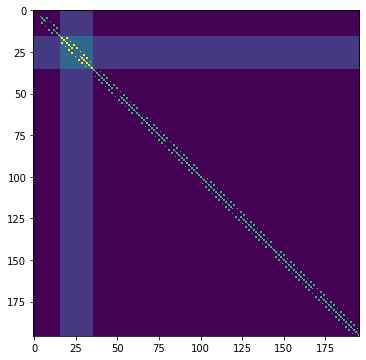

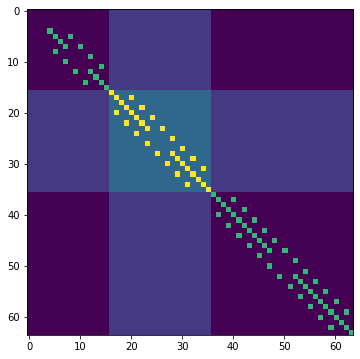

In [79]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = HMatElems(Hc2, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

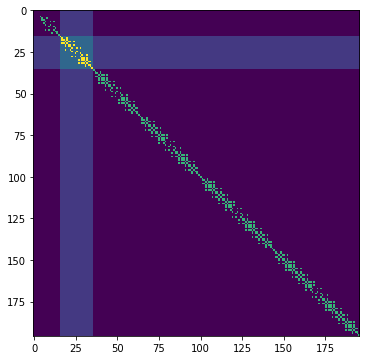

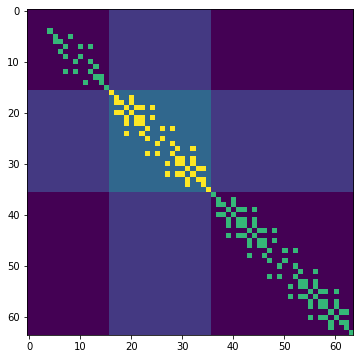

In [80]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = HMatElems(Hc3a, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

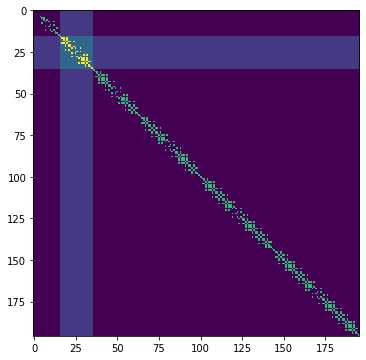

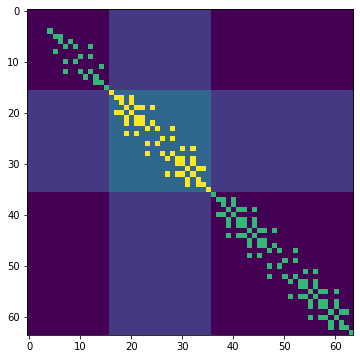

In [81]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = HMatElems(Hc3b, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

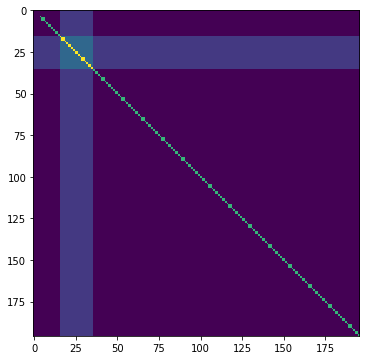

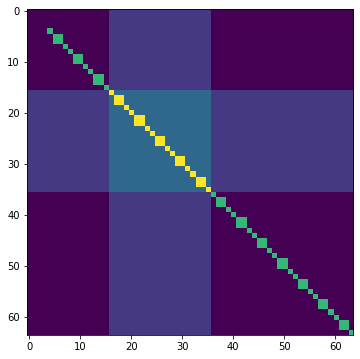

In [82]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = HMatElems(Hc3c, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

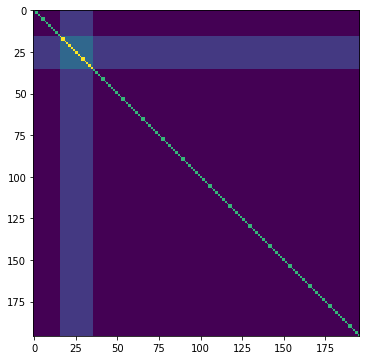

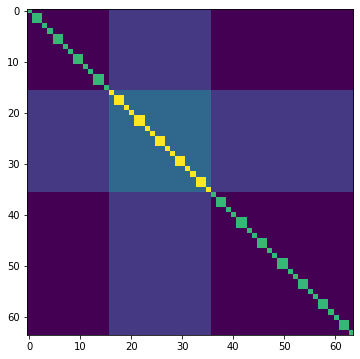

In [83]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = HMatElems(Hc4, QN)
H[H != 0] = 1
H = np.abs(H)

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

$H_{ff}$ does not intereact with any other states outside of $J=2$, use it as $H_0$

### Looking at $Hz$

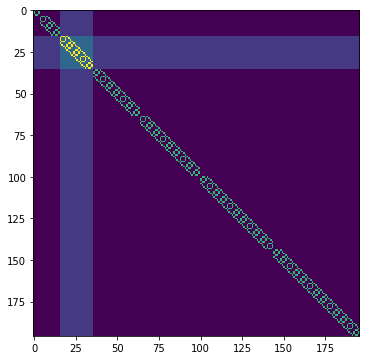

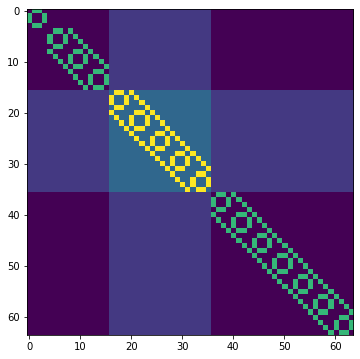

In [84]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = np.abs(HZx_m.copy())
H[H != 0] = 1

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

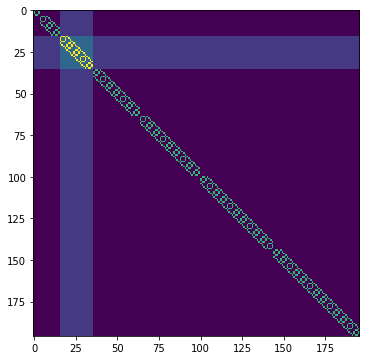

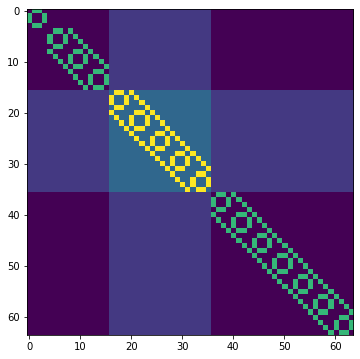

In [85]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = np.abs(HZy_m.copy())
H[H != 0] = 1

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

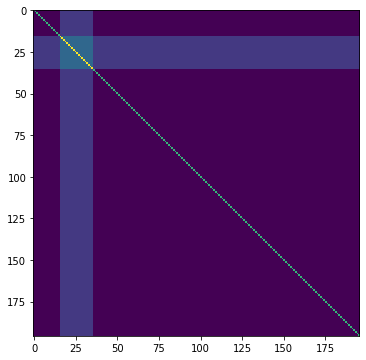

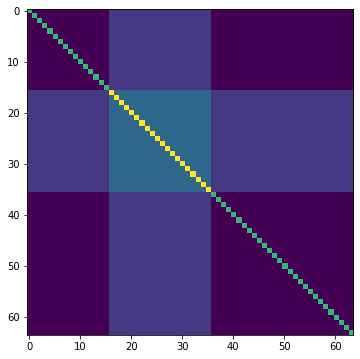

In [86]:
Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = np.abs(HZz_m.copy())
H[H != 0] = 1

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

No interactions outside of $J=2$ block, use as $H_0$

# Full Hamiltonian

In [434]:
def generate_effective_1st(QN, H, start, stop):
    l = stop-start
    Heff = np.zeros([l,l], dtype = 'complex')
    for idx in range(start,stop):
        val = 0
        for idy in range(0,len(QN)):
            if idx != idy:
                val += (1*QN[idx])@H(QN[idx])
        Heff[idx,idx] = val
    return Heff

def generate_effective_2nd(QN, H, H0, start, stop):
    E0, _ = np.linalg.eigh(H0)
    l = stop-start
    Heff = np.zeros([l, l], dtype = 'complex')
    for idx in range(start,stop):
        val = 0
        for idy in range(0,len(QN)):
            if idy not in range(start,stop):
                val += (1*QN[idx])@(H(QN[idy]))*(1*QN[idy])@H(QN[idx])/(E0[idx]-E0[idy])
        Heff[idx-start,idx-start] = val
    return Heff

def Heffective(Ex,Ey,Ez,H0,Heff):
    HSx_eff2nd,HSy_eff2nd,HSz_eff2nd = Heff
    return H0[16:36,16:36] + Ex**2*HSx_eff2nd + Ey**2*HSy_eff2nd + Ez**2*HSz_eff2nd

def Hfull(Ex, Ey, Ez,H0):
    return H0 + Ex*HSx_m + Ey*HSy_m + Ez*HSz_m

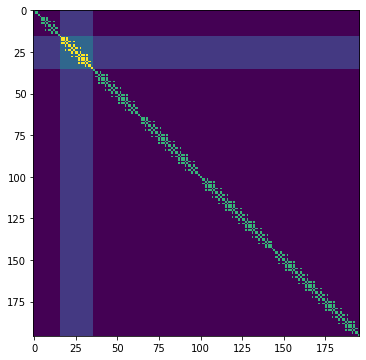

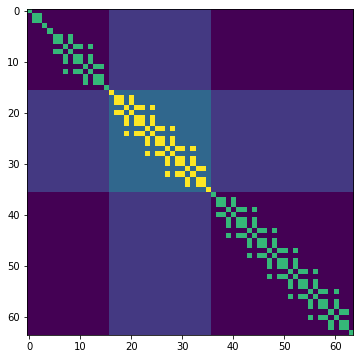

In [435]:
H0 = Hff_m + 0*HZx_m + 0*HZy_m + 0.5*HZz_m

Jmax = 3
idxmax = np.sum([4*(2*Ji+1) for Ji in range(Jmax+1)])

H = np.abs(H0.copy())
H[H != 0] = 1

Z = np.zeros(H.shape)
Z[:,16:36] += 0.25
Z[16:36,:] += 0.25

H = H+Z
# H[H==0.5] = 0

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(H[:idxmax, :idxmax])

In [436]:
H0 = Hff_m + 0*HZx_m + 0*HZy_m + 0.5*HZz_m

Heff = [generate_effective_2nd(QN, H, H0, 16,36) for H in [HSx, HSy, HSz]]

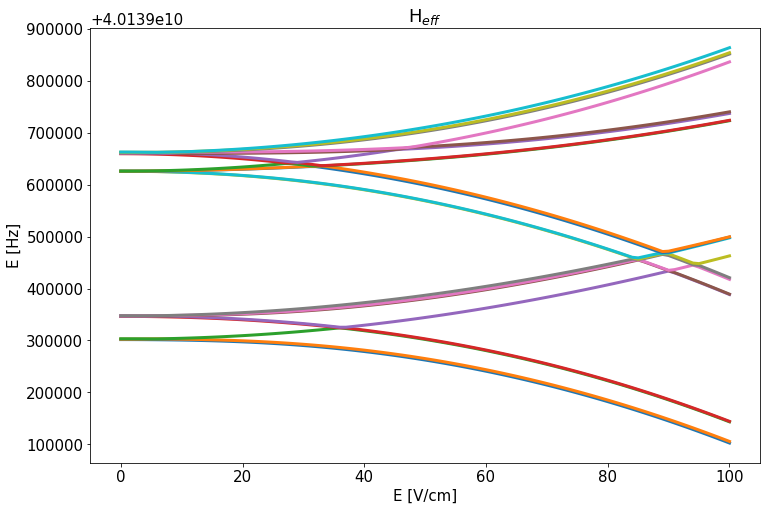

In [438]:
Ey = np.linspace(0,100,101)
Ez = np.linspace(0,100,101)

Heff_numerical = np.array([Heffective(0,Eyi,Ezi,H0, Heff) for Eyi, Ezi in zip(Ey,Ez)])
energies_eff, eigvecs = np.linalg.eigh(Heff_numerical)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(Ez, energies_eff, '-', lw = 3);
ax.set_title(r'H$_{eff}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

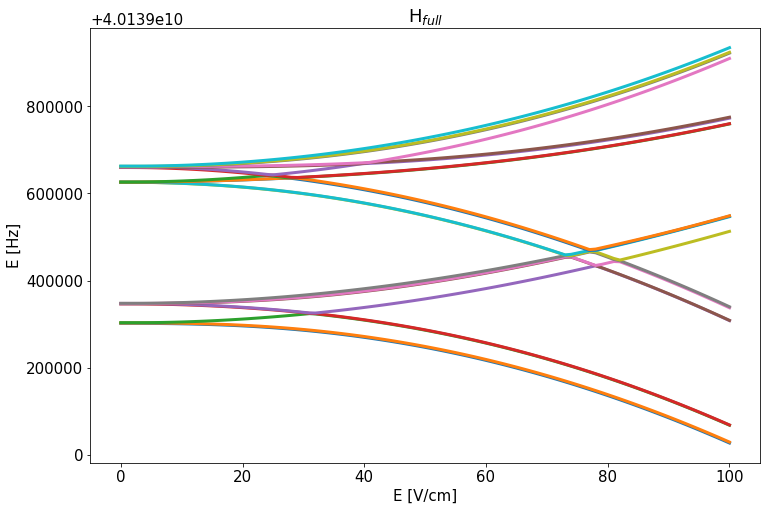

In [440]:
Hfull_numerical = np.array([Hfull(0,Eyi,Ezi,H0) for Eyi, Ezi in zip(Ey,Ez)])
energies_full, eigvecs = np.linalg.eigh(Hfull_numerical)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(Ez, energies_full[:,16:36], '-', lw = 3);
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

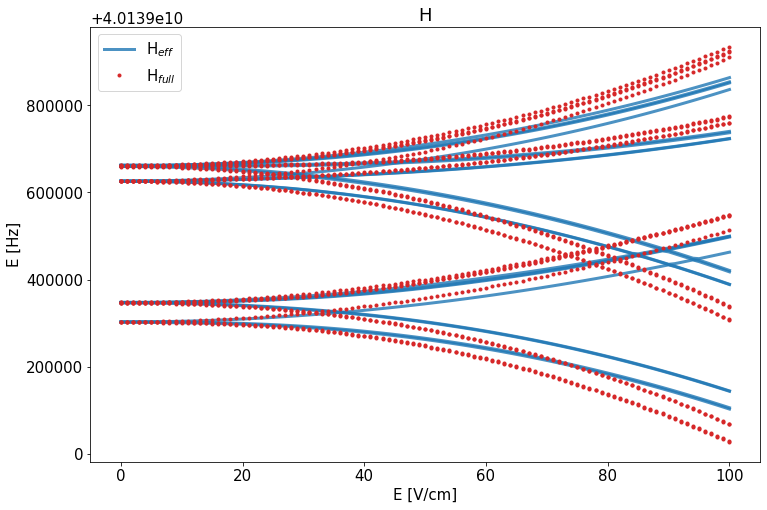

In [441]:
fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(Ez, energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(Ez, energies_full[:,16:36], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_title(r'H')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

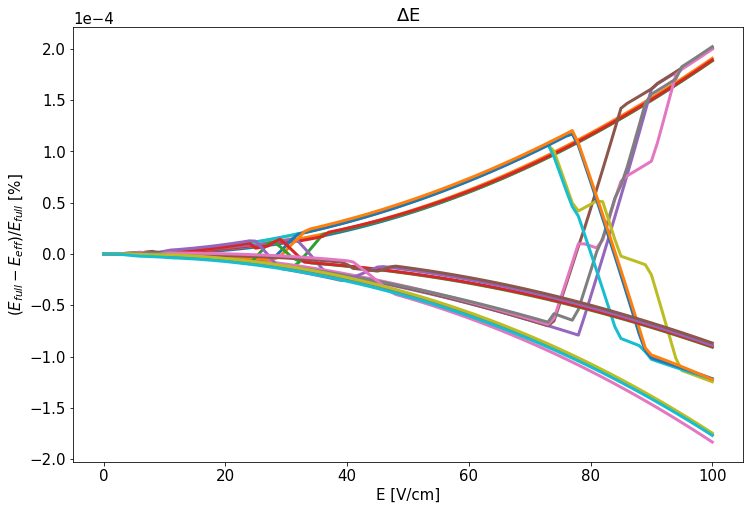

In [442]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(Ez, 100*(energies_eff-energies_full[:,16:36])/energies_full[:,16:36], lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

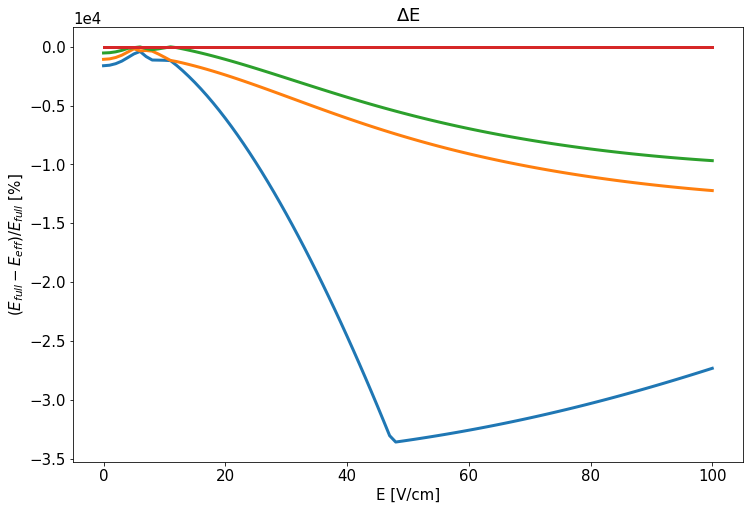

In [443]:
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(16,20):
    ax.plot(Ez, energies_eff[:,idx] - energies_eff[:,-1], lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

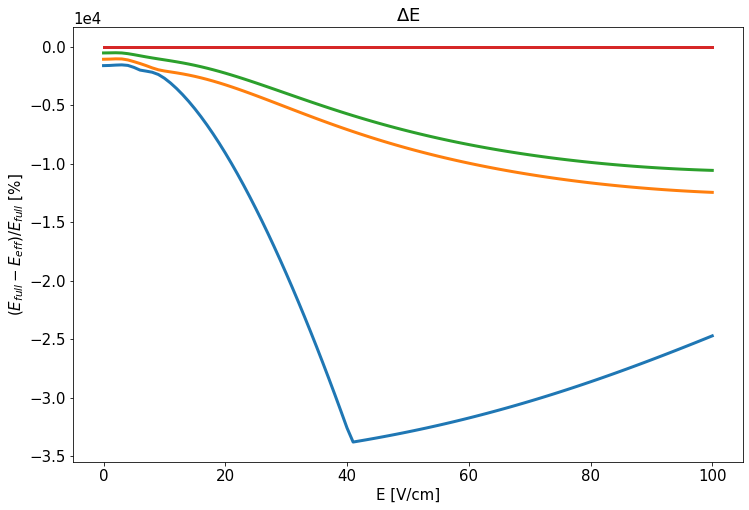

In [444]:
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(32,36):
    ax.plot(Ez, energies_full[:,idx] - energies_full[:,35], lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

# Checking Propagation with $H_{eff}$

In [170]:
from hamiltonianoperators import *

class HamiltonianEffective:
    def __init__(self, H0, Heff, start, stop):
        self.H0 = H0[start:stop, start:stop]
        self.HSx_m, self.HSy_m, self.HSz_m = Heff

    def create_hamiltonian(self, Ex,Ey,Ez):
        multi = lambda a, b: np.einsum('i,jk->ijk', a, b)
        if type(Ex) == np.ndarray:
            tmp = np.ones(len(Ex))
            HamE =  multi(tmp,self.H0) + \
                    multi(Ex**2,self.HSx_m) + multi(Ey**2,self.HSy_m) + \
                    multi(Ez**2,self.HSz_m)
        else:
            HamE =  self.H0 + \
                    Ex**2*self.HSx_m  + Ey**2*self.HSy_m + Ez**2*self.HSz_m
        return HamE

    def spectrum(self,  Ex, Ey, Ez):
        H = self.create_hamiltonian( Ex, Ey, Ez)
        return np.linalg.eigh(H)

In [166]:
from scipy import signal
from scipy.linalg import expm

def propagate_Vfield(ham, Emax, dEdt, B, steps, initState):
    t = np.linspace(-1,1,steps)
    E = (signal.sawtooth(t*np.pi, width = 0.5)+1)/2 * Emax
    t = (t+1) * Emax/dEdt
    
    H0 = ham.create_hamiltonian(0,0,E[0], *B)
    eigvals, eigvecs = np.linalg.eigh(H0)
    
    phi0 = eigvecs[:,initState]
    phii = phi0.copy()
    dt = np.diff(t)[0]
    H = np.empty([len(t),*H0.shape], dtype = 'complex')
    phi = np.empty([len(t), *phi0.shape], dtype = 'complex')
    
    dt = np.diff(t)[0]
    for idx, Ei in enumerate(E):
        Hi = ham.create_hamiltonian(0,0,Ei, *B)
        phii = (expm(-1j*Hi*dt)@phii)
        H[idx,:] = Hi
        phi[idx,:] = phii

    return t, E, phi, H

def propagate_Vfield_effective(ham, Emax, dEdt, steps, initState):
    t = np.linspace(-1,1,steps)
    E = (signal.sawtooth(t*np.pi, width = 0.5)+1)/2 * Emax
    t = (t+1) * Emax/dEdt
    
    H0 = ham.create_hamiltonian(0,0,E[0])
    eigvals, eigvecs = np.linalg.eigh(H0)
    
    phi0 = eigvecs[:,initState]
    phii = phi0.copy()
    dt = np.diff(t)[0]
    H = np.empty([len(t),*H0.shape], dtype = 'complex')
    phi = np.empty([len(t), *phi0.shape], dtype = 'complex')
    
    dt = np.diff(t)[0]
    for idx, Ei in enumerate(E):
        Hi = ham.create_hamiltonian(0,0,Ei)
        phii = (expm(-1j*Hi*dt)@phii)
        H[idx,:] = Hi
        phi[idx,:] = phii

    return t, E, phi, H

In [135]:
%%time
hamJ6 = Hamiltonian(6,0.5,0.5)

Wall time: 54.8 s


In [172]:
hamEff = HamiltonianEffective(H0, Heff, 16, 36)

Wall time: 11min 56s


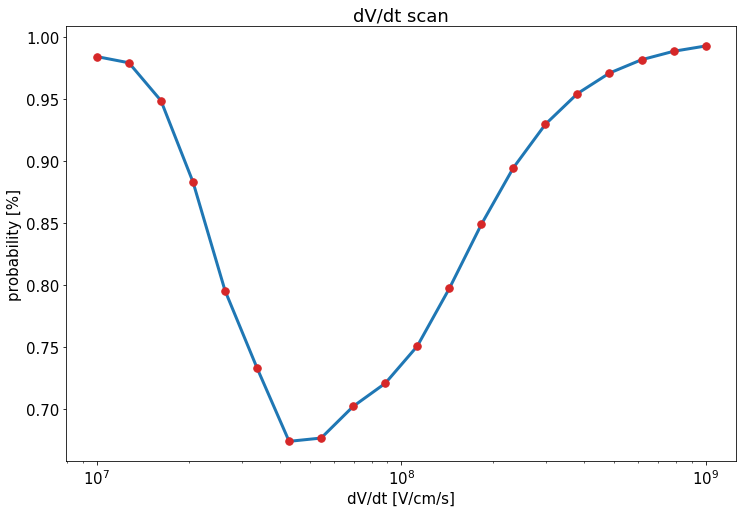

In [374]:
%%time

fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [%]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
dVdt = np.logspace(7,9,20)

for dV in dVdt:
    t,E,phi,H = propagate_Vfield(hamJ6, 500, dV, (0,0,0.5), 1500, 35)
    probabilities.append(np.abs(phi[-1].conj()@phi[0])**2)
    
    ax.cla()
    ax.plot(dVdt[:len(probabilities)], probabilities, lw = 3)
    ax.plot(dVdt[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('dV/dt [V/cm/s]')
    ax.set_ylabel('probability [%]')
    ax.set_title('dV/dt scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

Wall time: 29.7 s


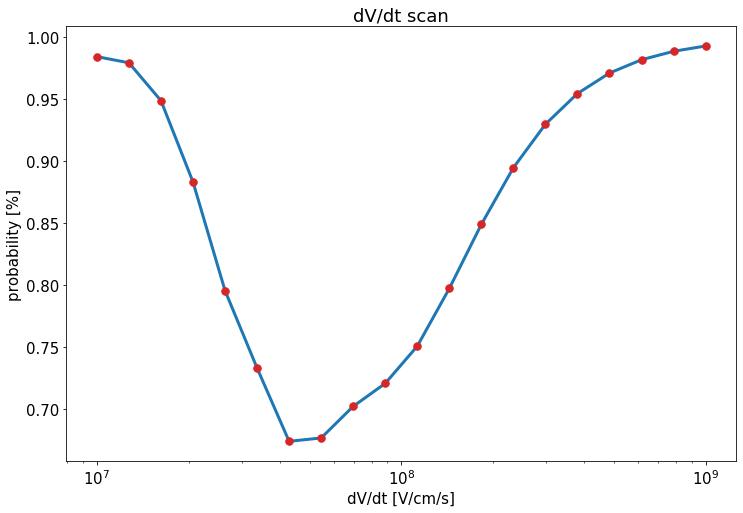

In [221]:
%%time 

fig, ax = plt.subplots(figsize = (12,8))
ax.set_xlabel('dV/dt [V/cm/s]')
ax.set_ylabel('probability [%]')
ax.set_title('dV/dt scan')
set_fontsize(ax, 15)

probabilities = []
dVdt = np.logspace(7,9,20)

for dV in dVdt:
    t,E,phi,H = propagate_Vfield_effective(hamEff, 500, dV, 1500, 19)
    probabilities.append(np.abs(phi[-1].conj()@phi[0])**2)
    
    ax.cla()
    ax.plot(dVdt[:len(probabilities)], probabilities, lw = 3)
    ax.plot(dVdt[:len(probabilities)], probabilities, '.C3', ms = 15)
    ax.set_xlabel('dV/dt [V/cm/s]')
    ax.set_ylabel('probability [%]')
    ax.set_title('dV/dt scan')
    ax.set_xscale('log')
    set_fontsize(ax, 15)
    display(fig)
    clear_output(wait = True)

In [358]:
def calculate_levels_populations(phi, H):
    eigvals, eigvecs = np.linalg.eigh(H)
    populations = np.empty(phi.shape)
    for idx, (phii, vec) in tqdm(enumerate(zip(phi, eigvecs)), total = len(eigvecs)):
        populations[idx,:] = np.abs(vec.T.conj()@phii)**2
    return eigvals, populations
    
def calculate_levels_populations_sorted(phi, phiSorted):
    populations = np.empty(phi.shape)
    for idx, (phiI, phiS) in enumerate(tqdm(zip(phi, phiSorted), total = len(phi))):
        for idy, p in enumerate(phiS.T):
            populations[idx,idy] = np.abs(p.conj()@phiI)**2
    return populations

In [359]:
%%time
t,E,phi,H = propagate_Vfield_effective(hamEff, 500, 5e7, 1500, 19)
energies, populations = calculate_levels_populations(phi, H)


Wall time: 1.33 s


In [360]:
%%time
from order_eigenstates import *
energiesSorted, eigenvectors, order = eigenshuffle(H, return_reorder = True)

Wall time: 1.46 s


In [361]:
populationsSorted = calculate_levels_populations_sorted(phi, eigenvectors)

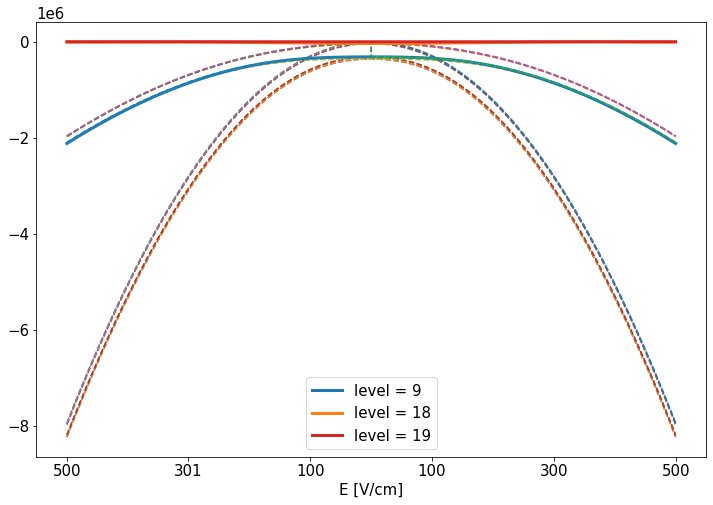

In [362]:
idxmax = len(E)
colors = ['C0', 'C1', 'C3', 'C4', 'C5', 'C6']
idc = 0
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(20):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,19], colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,19], '--')
pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
set_fontsize(ax, 15)

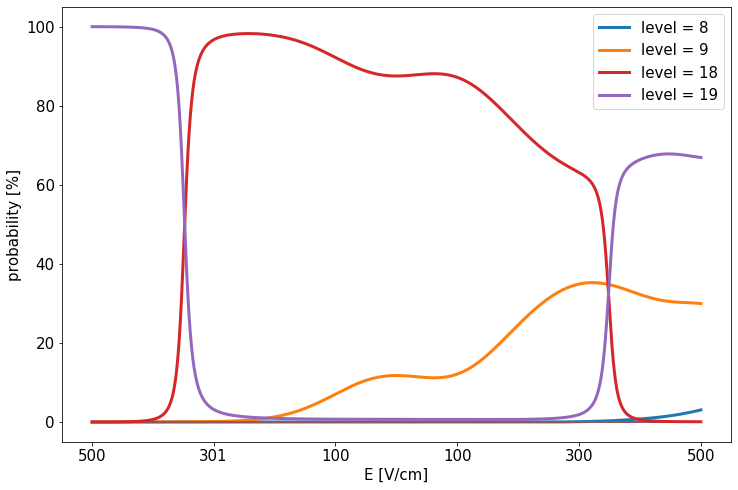

In [363]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5', 'C6']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(20):
    if idx in np.unique(np.where(populationsSorted > 0.01)[-1]):
        ax.plot(populationsSorted[:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(populationsSorted[:idxmax,idx]*100, '-')

pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('probability [%]')
set_fontsize(ax, 15)

In [369]:
%%time
t,E,phi,H = propagate_Vfield_effective(hamEff, 1000, 5e7, 2700, 19)
energies, populations = calculate_levels_populations(phi, H)


Wall time: 2.38 s


In [370]:
%%time
from order_eigenstates import *
energiesSorted, eigenvectors, order = eigenshuffle(H, return_reorder = True)

Wall time: 2.81 s


In [371]:
populationsSorted = calculate_levels_populations_sorted(phi, eigenvectors)

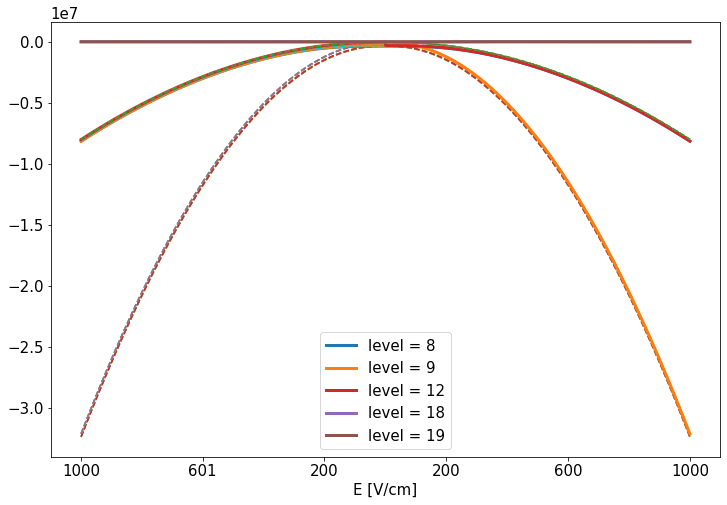

In [372]:
idxmax = len(E)
colors = ['C0', 'C1', 'C3', 'C4', 'C5', 'C6']
idc = 0
fig, ax = plt.subplots(figsize = (12,8))
for idx in range(20):
    if idx in np.unique(np.where(populationsSorted > 0.05)[-1]):
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,19], colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(energiesSorted[:idxmax,idx]-energiesSorted[:idxmax,19], '--')
pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
set_fontsize(ax, 15)

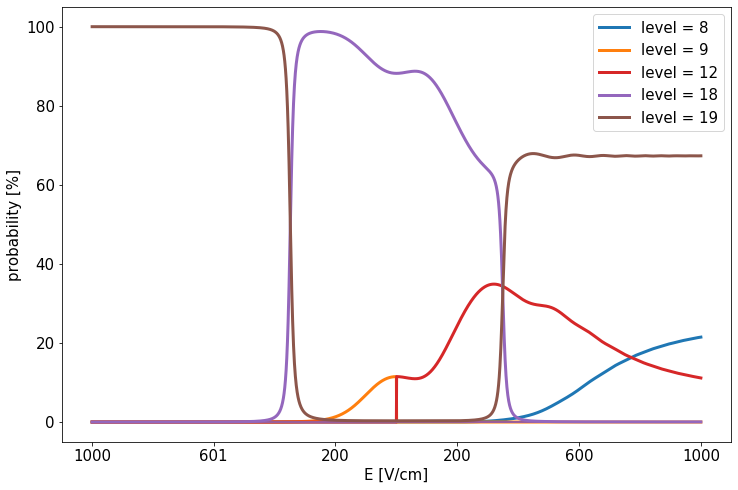

In [373]:
colors = ['C0', 'C1', 'C3', 'C4', 'C5', 'C6']
idc = 0

fig, ax = plt.subplots(figsize = (12,8))
for idx in range(20):
    if idx in np.unique(np.where(populationsSorted > 0.01)[-1]):
        ax.plot(populationsSorted[:idxmax,idx]*100, colors[idc], label = f'level = {idx}', lw = 3)
        idc += 1
    else:
        ax.plot(populationsSorted[:idxmax,idx]*100, '-')

pos = np.linspace(0,len(E)-1,6, dtype = int)
ax.set_xticks(pos)
ax.set_xticklabels([f'{Ei:.0f}'for Ei in E[pos]]);
ax.legend(fontsize = 15)
ax.set_xlabel('E [V/cm]')
ax.set_ylabel('probability [%]')
set_fontsize(ax, 15)

# Check High Field Limit
Determine at which field the $H_{eff}$ is not valid anymore

In [408]:
E = np.zeros([101,3])
E[:,2] = np.linspace(0,30000,101)
energies_eff = np.linalg.eigh(hamEff.create_hamiltonian(*E.T))[0]

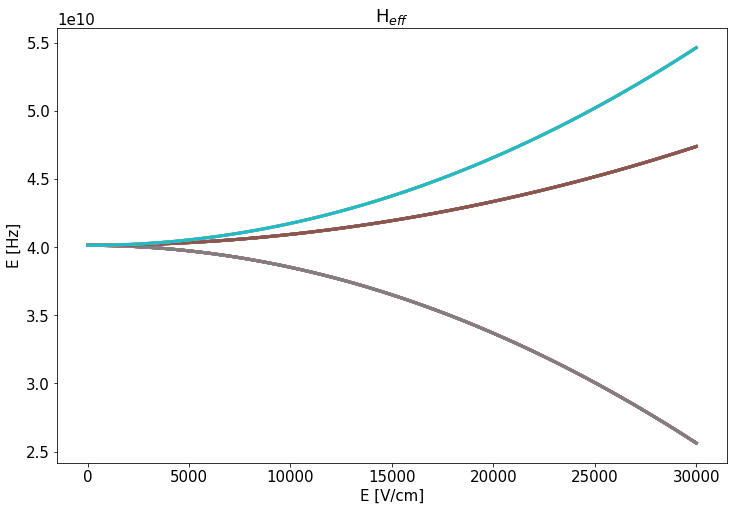

In [409]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E[:,2], energies_eff, lw = 3)
ax.set_title(r'H$_{eff}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

In [410]:
B = np.zeros(E.shape)
B[:,2] = 0.5
energies_full = np.linalg.eigh(hamJ6.create_hamiltonian(*E.T, *B.T))[0]
del B

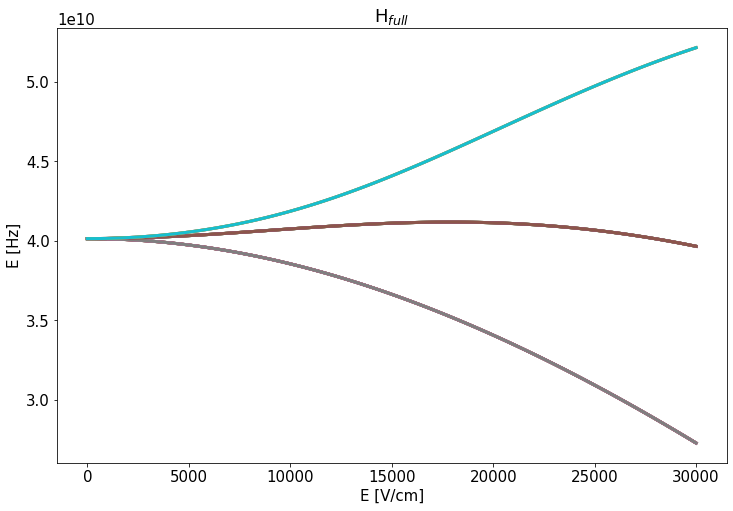

In [411]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E[:,2], energies_full[:,16:36], lw = 3)
ax.set_title(r'H$_{full}$')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

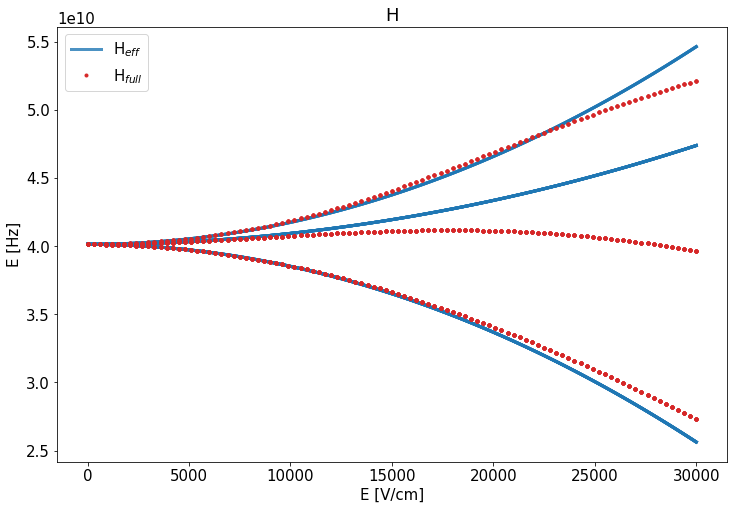

In [412]:
fig, ax = plt.subplots(figsize = (12,8))
l1 = ax.plot(E[:,2], energies_eff, 'C0-', lw = 3, label = r'H$_{eff}$', alpha = 0.8);
l2 = ax.plot(E[:,2], energies_full[:,16:36], 'C3.', label = r'H$_{full}$');
ax.legend([l1[0],l2[0]], [l1[0].get_label(),l2[0].get_label()], fontsize = 15)
ax.set_title(r'H')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'E [Hz]')
set_fontsize(ax, 15)

Need $\lambda^3$ and possibly higher order terms to correct for high field terms

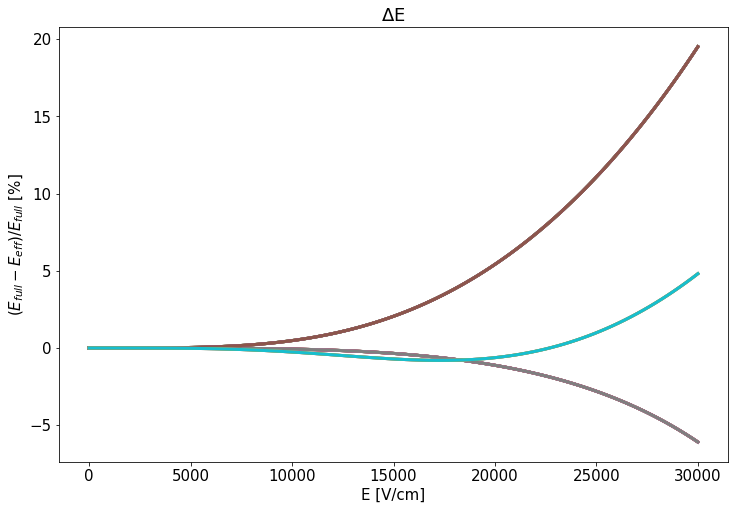

In [413]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E[:,2], 100*(energies_eff-energies_full[:,16:36])/energies_full[:,16:36], lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

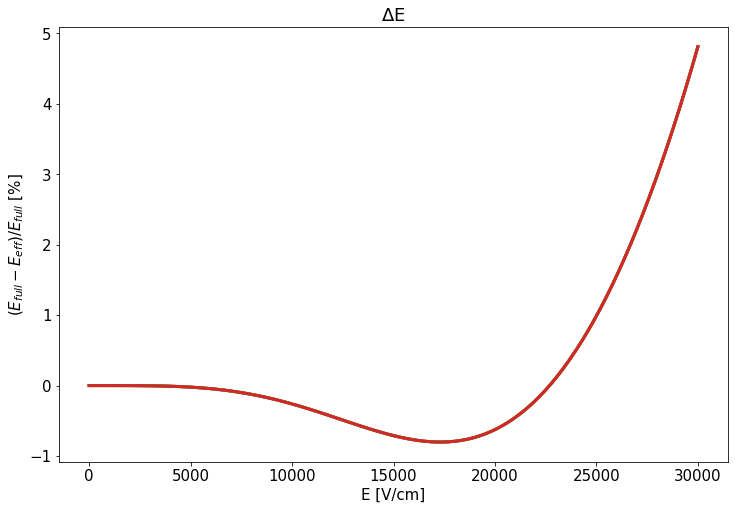

In [415]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(E[:,2], 100*(energies_eff[:,16:20]-energies_full[:,32:36])/energies_full[:,32:36], lw = 3);
ax.set_title(r'$\Delta$E')
ax.set_xlabel('E [V/cm]')
ax.set_ylabel(r'$\left(E_{full}-E_{eff}\right)/E_{full}$ [%]')
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
set_fontsize(ax, 15)

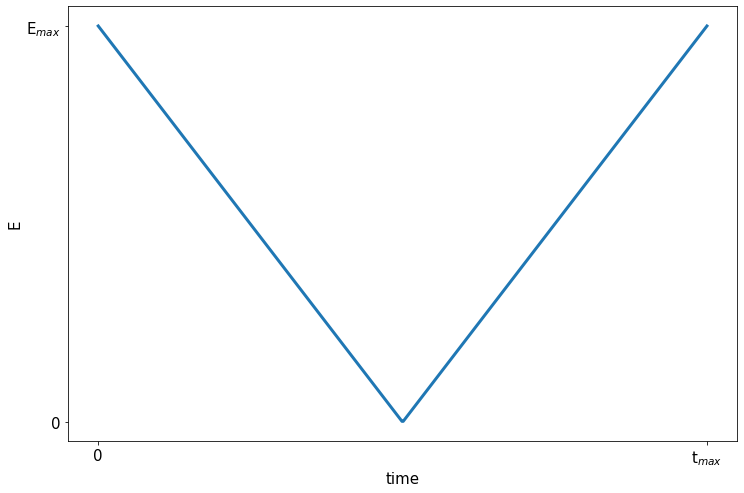

In [764]:
import scipy.signal

steps = 500
t = np.linspace(-1,1,steps)
E = (signal.sawtooth(t*np.pi, width = 0.5)+1)/2 * Emax
t += 1
t *= 0.5

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t, E, lw = 3)
ax.set_xlabel('time')
ax.set_ylabel('E')
ax.set_xticks([0,1])
ax.set_xticklabels(['0', r't$_{max}$'])
ax.set_yticks([0,500]);
ax.set_yticklabels(['0', r'E$_{max}$'])
set_fontsize(ax, 15)